In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

# Complex normal distribution

In [2]:
# create random variable for vectors of gamma distributed RV's
mutable struct ComplexNormal <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function ComplexNormal(out, μ, Γ, C; id=ForneyLab.generateId(ComplexNormal))
        @ensureVariables(out, μ, Γ, C)
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        ForneyLab.addNode!(currentGraph(), self)
        self.i[:out] = self.interfaces[1] = ForneyLab.associate!(Interface(self), out)
        self.i[:μ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), μ)
        self.i[:Γ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), Γ)
        self.i[:C] = self.interfaces[4] = ForneyLab.associate!(Interface(self), C)

        return self
    end
end

format(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = "$(slug(ComplexNormal))(μ=$(format(dist.params[:μ])), Γ=$(format(dist.params[:Γ])), C=$(format(dist.params[:C])))"

ProbabilityDistribution(::Type{ForneyLab.Multivariate}, ::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))
ProbabilityDistribution(::Type{ComplexNormal}; μ::Array{Complex{Float64},1}, Γ::Array{Complex{Float64},2}, C::Array{Complex{Float64},2}) = ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}(Dict(:μ=>μ, :Γ=>Γ, :C=>C))

function ForneyLab.prod!( x::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          y::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal},
                          z::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}=ProbabilityDistribution(ForneyLab.Multivariate, ComplexNormal, μ=zeros(size(x.params[:μ])).+0im, Γ=(1e10+1e10im)*Ic(length(x.params[:μ])), C=mat(0.0+0.0im)))

    # TOO SIMPLIFIED (CASE FOR C=0 -> circular symmetry)
    z.params[:Γ] = inv(inv(x.params[:Γ]) + inv(y.params[:Γ])) .+ 0.0im
    z.params[:μ] = z.params[:Γ]*(inv(x.params[:Γ])*x.params[:μ] + inv(y.params[:Γ])*y.params[:μ]) .+ 0.0im
    z.params[:C] = mat(0.0+0.0im)
        
    return z
end

unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
ForneyLab.unsafeMean(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:μ] # unsafe mean  
unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  
ForneyLab.unsafeCov(dist::ProbabilityDistribution{ForneyLab.Multivariate, ComplexNormal}) = dist.params[:Γ] # unsafe mean  

In [3]:
ruleSPComplexNormalOutNPPP(msg_out::Nothing, 
                           msg_μ::Message{PointMass},
                           msg_Γ::Message{PointMass},
                           msf_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_μ.dist.params[:μ]), Γ=deepcopy(msg_Γ.dist.params[:Γ]), C=deepcopy(msg_C.dist.params[:C]))

ruleSPComplexNormalOutNPPP (generic function with 1 method)

In [4]:
ruleSPComplexNormalIn1PNPP(msg_out::Message{PointMass}, 
                           msg_μ::Nothing,
                           msg_Γ::Message{PointMass},
                           msf_C::Message{PointMass}) =
                           Message(ForneyLab.Multivariate, ComplexNormal, μ=deepcopy(msg_out.dist.params[:μ]), Γ=deepcopy(msg_Γ.dist.params[:Γ]), C=deepcopy(msg_C.dist.params[:C]))

ruleSPComplexNormalIn1PNPP (generic function with 1 method)

In [5]:
ruleVBComplexNormalOut(dist_out::Any,
                       dist_μ::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_μ), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalOut (generic function with 1 method)

In [6]:
ruleVBComplexNormalIn1(dist_out::ProbabilityDistribution{ForneyLab.Multivariate},
                       dist_μ::Any,
                       dist_Γ::ProbabilityDistribution{ForneyLab.MatrixVariate},
                       dist_C::ProbabilityDistribution{ForneyLab.MatrixVariate}) =
                       Message(ForneyLab.Multivariate, ComplexNormal, μ=ForneyLab.unsafeMean(dist_out), Γ=ForneyLab.unsafeMean(dist_Γ), C=ForneyLab.unsafeMean(dist_C))

ruleVBComplexNormalIn1 (generic function with 1 method)

In [7]:
@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Nothing, Message{PointMass}, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalOutNPP)

@sumProductRule(:node_type     => ComplexNormal,
                :outbound_type => Message{ComplexNormal},
                :inbound_types => (Message{PointMass}, Nothing, Message{PointMass}, Message{PointMass}),
                :name          => SPComplexNormalIn1NPP)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalOut)

@naiveVariationalRule(:node_type     => ComplexNormal,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VBComplexNormalIn1)

# Hierarchical Gaussian filter

In [8]:
mutable struct HGF <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function HGF(X, ξ; id=ForneyLab.generateId(HGF))
        
        # ensure that the input arguments are random variables
        @ensureVariables(X, ξ) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 2), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:X] = self.interfaces[1] = ForneyLab.associate!(Interface(self), X)
        self.i[:ξ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), ξ)
        
        # return object
        return self
    end
end

In [9]:
function ruleVariationalHGFOutNP(marg_X::Nothing, 
                                 marg_ξ::ProbabilityDistribution{ForneyLab.Multivariate})
    
    # caluclate required mean
    mξ = ForneyLab.unsafeMean(marg_ξ)

    # calculate required variance
    vξ = diag(ForneyLab.unsafeCov(marg_ξ))

    # calculate new parameters
    mX = zeros(size(mξ)) .+ 0im
    vX = exp.(mξ - vξ/2) .+ 0im
    
    # create variational message
    return Message(ForneyLab.Multivariate, ComplexNormal, μ=mX, Γ=diagm(vX), C=mat(0.0+0.0im))

end

ruleVariationalHGFOutNP (generic function with 1 method)

In [10]:
function ruleVariationalHGFIn1PN(marg_X::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                 marg_ξ::Nothing)
    
    # calculate required means
    mX = ForneyLab.unsafeMean(marg_X)

    # calculate required variances
    vX = diag(ForneyLab.unsafeCov(marg_X))

    # calculate new parameters
    mξ = log.(abs2.(mX) + real.(vX))
    vξ = 1.0*ones(length(mξ))

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=mξ./vξ, w=diagm(1 ./ vξ))

end

ruleVariationalHGFIn1PN (generic function with 1 method)

In [11]:
@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{ComplexNormal},
                      :inbound_types => (Nothing, ProbabilityDistribution),
                      :name          => VariationalHGFOutNP)

@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing),
                      :name          => VariationalHGFIn1PN)

## Factor graph

In [12]:
# number of frequency bins 
nr_freqs = 5

# create factor graph
fg = FactorGraph()

# gaussian mixture 
@RV [id=:ξ] ξ ~ GaussianMeanVariance(placeholder(:μ_ξ, dims=(nr_freqs,)), placeholder(:Σ_ξ, dims=(nr_freqs,nr_freqs)))

# HGF
@RV [id=:X] X ~ HGF(ξ)

# observation model
@RV [id=:y] y ~ ComplexNormal(X, placeholder(:Σ_y, dims=(nr_freqs,nr_freqs)), mat(0.0+0.0im))
placeholder(y, :y, dims=(nr_freqs,))

# draw graph
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14260923139631754417 -->
 14260923139631754417 
 
 placeholder_Σ_y 
 
<!-- 6786647979742980866 -->
 6786647979742980866 
 
 placeholder_y 
 
<!-- 3663060049341228766 -->
 3663060049341228766 
 
 ComplexNormal 
 complexnormal_1 
 
<!-- 6786647979742980866--3663060049341228766 -->
 6786647979742980866--3663060049341228766 
 
 y 
 1 out 
 1 out 
 
<!-- 10143694323003098131 -->
 10143694323003098131 
 
 HGF 
 hgf_1 
 
<!-- 7906786618100845641 -->
 7906786618100845641 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 10143694323003098131--7906786618100845641 -->
 10143694323003098131--7906786618100845641 
 
 ξ 
 1 out 
 2 ξ 
 
<!-- 3323974771329118815 -->
 3323974771329118815 
 
 placeholder_Σ_ξ 
 
<!-- 3298797449712972471 -->
 3298797449712972471 
 
 clamp_1 
 
<!-- 3663060049341228766--14260923139631754417 -->
 3663060049341228766--14260923139631754417 
 
 Σ_y 
 1 out 
 3 Γ 
 
<!-- 3663060049341228766--10143694323003098131 -->
 3663060049341228766--10143694323003098131 
 
 X 
 1 X 
 2 μ 
 
<!-- 3663060049341228766--3298797449712972471 -->
 3663060049341228766--3298797449712972471 
 
 clamp_1 
 1 out 
 4 C 
 
<!-- 13663358509000810982 -->
 13663358509000810982 
 
 placeholder_μ_ξ 
 
<!-- 7906786618100845641--3323974771329118815 -->
 7906786618100845641--3323974771329118815 
 
 Σ_ξ 
 1 out 
 3 v 
 
<!-- 7906786618100845641--13663358509000810982 -->
 7906786618100845641--13663358509000810982 
 
 μ_ξ 
 1 out 
 2 m

## Data generation

In [13]:
# generate data
N = 10000

μ_ξi = 1.0*collect(-4:2:4)
Σ_ξ = 1e-4*diagm(ones(nr_freqs))
Σ_meas = 1e-10*Ic(nr_freqs)

ξ_samples = Array{Float64,2}(undef, N, nr_freqs)
X_samples = Array{Complex{Float64},2}(undef, N, nr_freqs)
y_samples = Array{Complex{Float64},2}(undef, N, nr_freqs)

for n = 1:N

#     sample_ξ = rand(MvNormal(μ_ξ, Σ_ξ))
#     sample_X = rand(MvNormal(zeros(nr_freqs), real.((exp.(0.5*sample_ξ))))) + 1im*rand(MvNormal(zeros(nr_freqs), real.((exp.(0.5*sample_ξ)))))
#     sample_y = rand(MvNormal(real(sample_X), 0.5*real.(Σ_meas))) + 1im*rand(MvNormal(imag(sample_X), 0.5*real.(Σ_meas)))
    
#     ξ_samples[n,:] = sample_ξ
#     X_samples[n,:] = sample_X
#     y_samples[n,:] = sample_y
    for k = 1:nr_freqs
        sample_ξ = rand(Normal(μ_ξi[k], sqrt(Σ_ξ[k,k])))
        sample_X = rand(Normal(0, sqrt(0.5*exp(sample_ξ)))) + 1im*rand(Normal(0, sqrt(0.5*exp(sample_ξ))))
        sample_y = rand(Normal(real(sample_X), sqrt(0.5*Σ_meas[k,k]))) + 1im*rand(Normal(imag(sample_X), sqrt(0.5*Σ_meas[k,k])))

        ξ_samples[n,k] = sample_ξ
        X_samples[n,k] = sample_X
        y_samples[n,k] = sample_y
    end
end

t = collect(1:N)
;

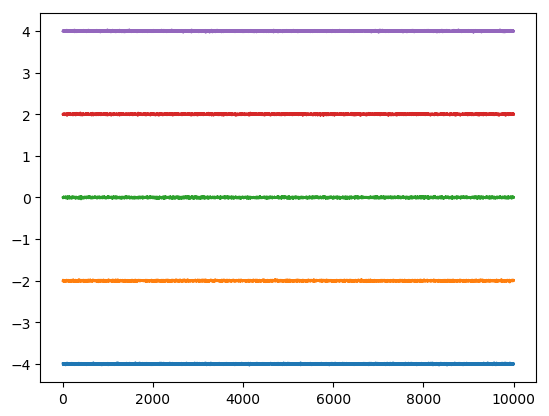

In [14]:
plt.plot(t, ξ_samples);

In [15]:
mean(ξ_samples[:,1]), var(ξ_samples[:,1])

(-4.000179898158945, 0.00010156982996634659)

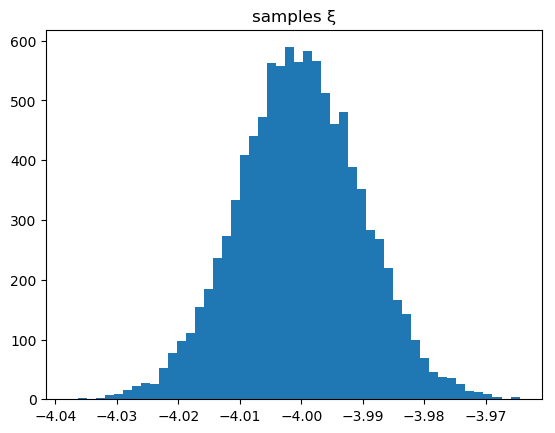

In [16]:
plt.hist(ξ_samples[:,1], bins=50), plt.title("samples ξ");

In [17]:
var(real(X_samples[:,1])), var(imag(X_samples[:,1])), 0.5*exp(1)

(0.009084489840704509, 0.00914356621417521, 1.3591409142295225)

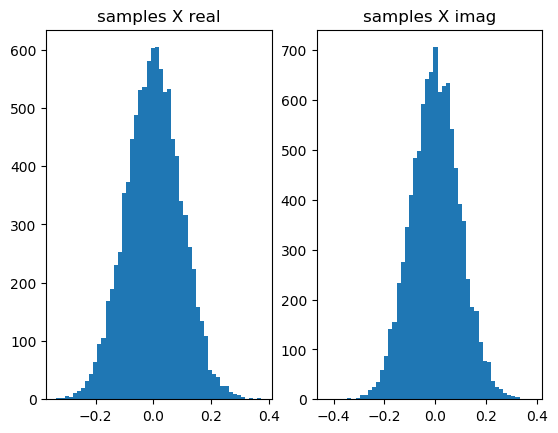

In [18]:
_,ax = plt.subplots(ncols=2); ax[1].hist(real(X_samples[:,1]), bins=50), ax[1].set_title("samples X real"), ax[2].hist(imag(X_samples[:,1]), bins=50), ax[2].set_title("samples X imag");

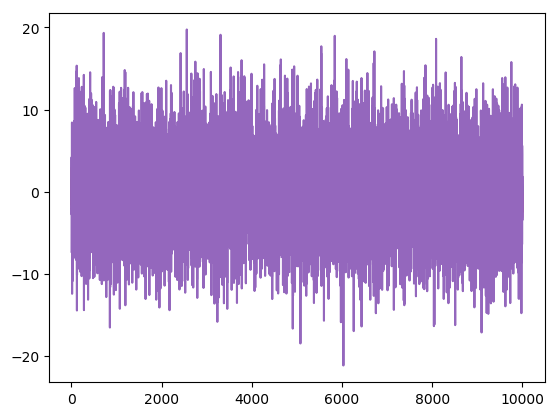

C:\Users\s151781\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [19]:
plt.plot(t, X_samples);

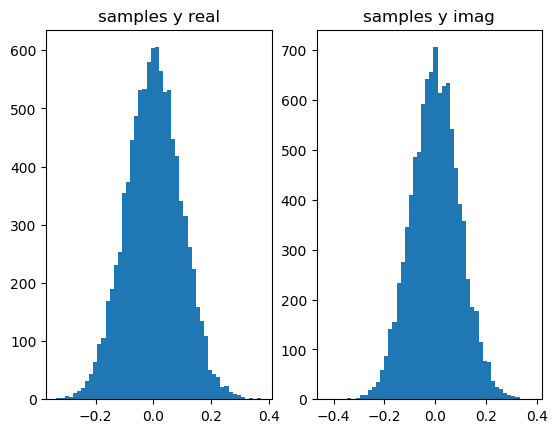

In [20]:
_,ax = plt.subplots(ncols=2); ax[1].hist(real(y_samples[:,1]), bins=50), ax[1].set_title("samples y real"), ax[2].hist(imag(y_samples[:,1]), bins=50), ax[2].set_title("samples y imag");

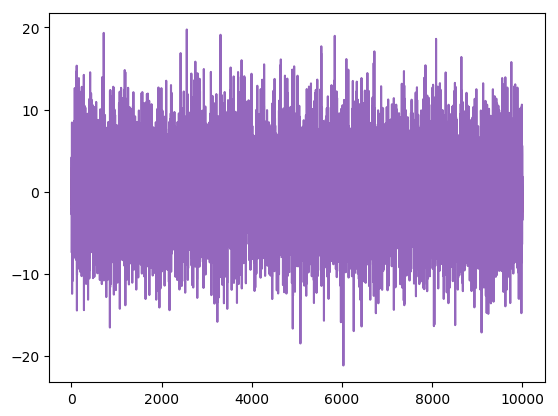

In [21]:
plt.plot(t,y_samples);

## Inference 

In [22]:
q = PosteriorFactorization(X, ξ, ids=[:X :ξ])
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepξ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_ξ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_ξ]))
messages[2] = ruleVariationalHGFIn1PN(marginals[:X], nothing)

marginals[:ξ] = messages[1].dist * messages[2].dist

return marginals

end

function stepX!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVariationalHGFOutNP(nothing, marginals[:ξ])
messages[2] = ruleVBComplexNormalIn1(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_y]), ProbabilityDistribution(MatrixVariate, PointMass, m=mat(0.0 + 0.0im)))

marginals[:X] = messages[1].dist * messages[2].dist

return marginals

end

end # block


In [23]:
μ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)
Σ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)

# priors
μ_ξ = zeros(nr_freqs)
Σ_ξ = 1*Ic(nr_freqs)
Σ_y = 1e-10*Ic(nr_freqs).+0im# .+ 1im*0.5*1e-10*Ic(nr_freqs)

marginals = Dict()

for n = 1:N
        
    # fill marginals dictionary
    marginals[:ξ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_ξ, v=Σ_ξ)
    
    # fill data dictionary
    data = Dict()
    data[:μ_ξ] = μ_ξ
    data[:Σ_ξ] = Σ_ξ
    data[:Σ_y] = Σ_y
    data[:y] = y_samples[n,:]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(stepX!, data, marginals)
        Base.invokelatest(stepξ!, data, marginals)
    end
    
    # update parameters
    μ_ξ = ForneyLab.unsafeMean(marginals[:ξ])
    Σ_ξ = ForneyLab.unsafeCov(marginals[:ξ])

    # save parameters
    μ_ξ_mem[n,:] = μ_ξ
    Σ_ξ_mem[n,:] = diag(Σ_ξ)
    
end

In [24]:
mean(marginals[:ξ])

5-element Array{Float64,1}:
 -4.586621388495511 
 -2.602787220666117 
 -0.569872954341272 
  1.4275573506371313
  3.4238186111822637

In [25]:
cov(marginals[:ξ])

5×5 Array{Float64,2}:
  9.999e-5   0.0        0.0        0.0       -0.0     
  0.0        9.999e-5   0.0        0.0       -0.0     
  0.0        0.0        9.999e-5   0.0       -0.0     
  0.0        0.0        0.0        9.999e-5  -0.0     
 -0.0       -0.0       -0.0       -0.0        9.999e-5

In [26]:
ForneyLab.unsafeMean(marginals[:X])

5-element Array{Complex{Float64},1}:
 0.15920578380143913 - 0.015481489364851076im
 0.04926478385053912 + 0.368771784236252im   
 -0.9124305328937559 + 0.1350254411445235im  
 -2.4222057252315907 + 1.4718596748936643im  
  1.7567544897442524 - 3.3598240567091433im  

In [27]:
ForneyLab.unsafeCov(marginals[:X])

5×5 Array{Complex{Float64},2}:
 1.0e-10+0.0im      0.0+0.0im      0.0+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.0e-10+0.0im      0.0+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.0e-10+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im  1.0e-10+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im      0.0+0.0im  1.0e-10+0.0im

In [28]:
log.(abs2.(ForneyLab.unsafeMean(marginals[:X])))

5-element Array{Float64,1}:
 -3.665703772602573  
 -1.9774652821704932 
 -0.16162362791392293
  2.0836142585157225 
  2.6654630405146706 

## Results

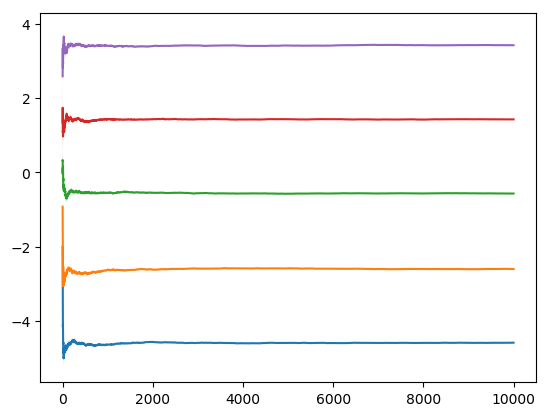

In [29]:
for k = 1:nr_freqs
    plt.plot(t, μ_ξ_mem[:,k])
    plt.fill_between(t, μ_ξ_mem[:,k] - sqrt.(Σ_ξ_mem[:,k]), μ_ξ_mem[:,k] + sqrt.(Σ_ξ_mem[:,k]), alpha=0.3)
end


In [30]:
μ_ξ_mem

10000×5 Array{Float64,2}:
 -2.01082  -0.924717   0.325559   1.34006   2.58691
 -2.52094  -1.52832    0.331786   1.7399    3.15527
 -2.77207  -1.708      0.0739047  1.69836   3.33794
 -3.05296  -1.95454   -0.0483725  1.08458   3.24935
 -3.5262   -2.09371    0.117876   1.27607   3.23467
 -3.73283  -2.29424    0.125868   1.10684   3.09086
 -4.17165  -2.20747   -0.0232524  1.09576   2.81952
 -4.10092  -3.06601    0.12337    1.00269   2.9344 
 -4.19768  -2.84871    0.152435   0.967173  2.96984
 -4.31103  -2.88892    0.0176332  1.04252   2.90986
 -4.26734  -2.7566    -0.0394589  1.08671   3.02824
 -4.50304  -2.70217   -0.0174451  1.14513   3.21495
 -4.62837  -2.6149    -0.100076   1.18955   3.30586
  ⋮                                                
 -4.58685  -2.60264   -0.570328   1.42726   3.42389
 -4.58674  -2.60273   -0.570166   1.42717   3.42386
 -4.58662  -2.60275   -0.570014   1.42719   3.42383
 -4.58656  -2.60265   -0.569837   1.42726   3.42397
 -4.58656  -2.60261   -0.570031   1.42

In [31]:
Σ_ξ_mem

10000×5 Array{Float64,2}:
 0.5         0.5         0.5         0.5         0.5       
 0.333333    0.333333    0.333333    0.333333    0.333333  
 0.25        0.25        0.25        0.25        0.25      
 0.2         0.2         0.2         0.2         0.2       
 0.166667    0.166667    0.166667    0.166667    0.166667  
 0.142857    0.142857    0.142857    0.142857    0.142857  
 0.125       0.125       0.125       0.125       0.125     
 0.111111    0.111111    0.111111    0.111111    0.111111  
 0.1         0.1         0.1         0.1         0.1       
 0.0909091   0.0909091   0.0909091   0.0909091   0.0909091 
 0.0833333   0.0833333   0.0833333   0.0833333   0.0833333 
 0.0769231   0.0769231   0.0769231   0.0769231   0.0769231 
 0.0714286   0.0714286   0.0714286   0.0714286   0.0714286 
 ⋮                                                         
 0.0001001   0.0001001   0.0001001   0.0001001   0.0001001 
 0.00010009  0.00010009  0.00010009  0.00010009  0.00010009
 0.00010008  0

In [32]:
μ_ξi  .- μ_ξ_mem[end,:] 

5-element Array{Float64,1}:
 0.5866213884955114
 0.6027872206661171
 0.569872954341272 
 0.5724426493628687
 0.5761813888177363

In [33]:
mean(μ_ξi  .- μ_ξ_mem[end,:])

0.5815811203367011

In [34]:
log(pi), 0.5*log(pi), 1/sqrt(pi)

(1.1447298858494002, 0.5723649429247001, 0.5641895835477563)